# Прогнозирование температуры плавления стали

# Содержание

1. [Цель](#purpose)
2. [Описание](#description)
2. [Исследовательский анализ данных](#analysis)
3. [План работы](#work_plan)
4. [Подготовка данных](#data_preparation)
5. [Построение моделей](#building_models)
6. [Вывод](#conclusion)

## Цель проекта  <a id="purpose"></a>

Построить модель, которая предскажет температуру стали, поможет оптимизировать расходы и энергопотребление на этапе обработки.

## Описание проекта <a id="description"></a>

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).


## Описание данных

Данные состоят из файлов, полученных из разных источников:

•	data_arc_new.csv — данные об электродах;

•	data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

•	data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

•	data_gas_new.csv — данные о продувке сплава газом;

•	data_temp_new.csv — результаты измерения температуры;

•	data_wire_new.csv — данные о проволочных материалах (объём);

•	data_wire_time_new.csv — данные о проволочных материалах (время).


Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.


# 1.Исследовательский анализ данных <a id="analysis"></a>

Импортируем все необходимое для работы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint
from scipy.stats import uniform
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

Отключаем предупреждения

In [2]:
import warnings
warnings.filterwarnings('ignore')

Импортируем данные 

In [3]:
try:
    arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
    bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')
            
except:
    arc_new = pd.read_csv('data_arc_new.csv')
    bulk_new = pd.read_csv('data_bulk_new.csv')
    bulk_time_new = pd.read_csv('data_bulk_time_new.csv')
    gas_new = pd.read_csv('data_gas_new.csv')
    temp_new = pd.read_csv('data_temp_new.csv')
    wire_new = pd.read_csv('data_wire_new.csv')
    wire_time_new = pd.read_csv('data_wire_time_new.csv')  

Поместим файлы в список для более удобного выведения информации о наличии дубликатов

In [4]:
datas = [arc_new, bulk_new, bulk_time_new, gas_new, temp_new, wire_new, wire_time_new]

In [5]:
for data in datas:
    print(data.duplicated().sum())

0
0
0
0
0
0
0


Дубликатов нет

### Данные об электродах

In [6]:
arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Переведем названия столбцов на английский язык и запишем их в нижнем регистре.

Изменим тип данных для столбцов с указанием временем

In [8]:
arc_new.columns = ['key', 'arc_heating_start', 'arc_heating_end', 'active_power', 'reactive_power']

Даты хранятся в столбцах с типом object, приведем их к типу datetime.

In [9]:
arc_new['arc_heating_start'] = pd.to_datetime(arc_new['arc_heating_start'])
arc_new['arc_heating_end'] = pd.to_datetime(arc_new['arc_heating_end'])

In [10]:
arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   arc_heating_start  14876 non-null  datetime64[ns]
 2   arc_heating_end    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [11]:
arc_new.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Минимальное значение мощности в столбце reactive_power = -715.479924, скорее всего это выброс и на этапе предобработки данных его можно будет удалить. При построении графиков учтем этот момент.

In [12]:
len(arc_new['key'].unique())

3214

In [13]:
arc_new['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

Text(0.5, 0, 'Количество итераций в одной партии')

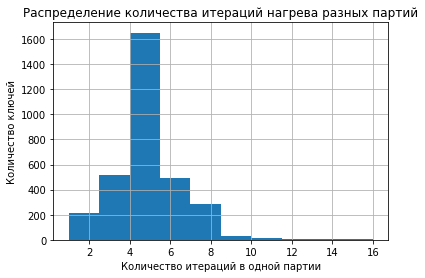

In [14]:
plt.figure()
arc_new.groupby('key')['active_power'].count().hist()
plt.title('Распределение количества итераций нагрева разных партий')
plt.ylabel('Количество ключей')
plt.xlabel('Количество итераций в одной партии')

В среднем проводится 5 итераций для одной партии

Построим гисторграмму с учетом того, что реактивная мощность нее может быть меньше 0

Text(0.5, 0, 'Реактивная мощность')

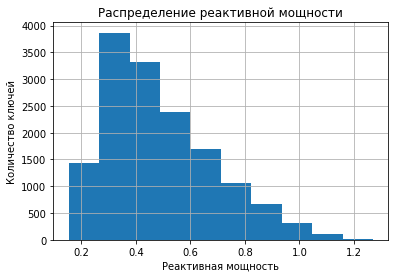

In [15]:
arc_new[arc_new['reactive_power'] > 0]['reactive_power'].hist()
plt.title('Распределение реактивной мощности')
plt.ylabel('Количество ключей')
plt.xlabel('Реактивная мощность')

В среднем показания реактивной мощности находятся в диапазоне от 0.3 до 0.6

### Данные о подаче сыпучих материалов (объём)

In [16]:
bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Для удобства изменим названия столбцов

In [17]:
bulk_new = bulk_new.rename(
    columns = {
        'Bulk 1': 'bulk_1',
        'Bulk 2': 'bulk_2',
        'Bulk 3': 'bulk_3',
        'Bulk 4': 'bulk_4',
        'Bulk 5': 'bulk_5',
        'Bulk 6': 'bulk_6',
        'Bulk 7': 'bulk_7',
        'Bulk 8': 'bulk_8',
        'Bulk 9': 'bulk_9',
        'Bulk 10': 'bulk_10',
        'Bulk 11': 'bulk_11',
        'Bulk 12': 'bulk_12',
        'Bulk 13': 'bulk_13',
        'Bulk 14': 'bulk_14',
        'Bulk 15': 'bulk_15'
    }
)

In [18]:
bulk_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [19]:
bulk_new.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [20]:
len(bulk_new['key'].unique())

3129

In [21]:
bulk_new['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

### Данные о подаче сыпучих материалов (время)

In [22]:
bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [23]:
bulk_time_new = bulk_time_new.rename(
    columns = {
        'Bulk 1': 'bulk_1',
        'Bulk 2': 'bulk_2',
        'Bulk 3': 'bulk_3',
        'Bulk 4': 'bulk_4',
        'Bulk 5': 'bulk_5',
        'Bulk 6': 'bulk_6',
        'Bulk 7': 'bulk_7',
        'Bulk 8': 'bulk_8',
        'Bulk 9': 'bulk_9',
        'Bulk 10': 'bulk_10',
        'Bulk 11': 'bulk_11',
        'Bulk 12': 'bulk_12',
        'Bulk 13': 'bulk_13',
        'Bulk 14': 'bulk_14',
        'Bulk 15': 'bulk_15'
    }
)

In [24]:
bulk_time_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [25]:
for column in bulk_time_new.columns:
    if column[0] == 'b':
        bulk_time_new[column] = pd.to_datetime(bulk_time_new[column])

In [26]:
bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [27]:
len(bulk_time_new['key'].unique())

3129

In [28]:
bulk_time_new['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

Text(0.5, 0, 'Наименование сыпучего материала')

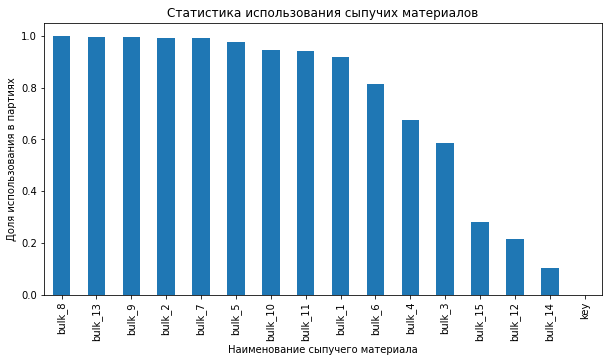

In [29]:
plt.figure(figsize = (10,5))
bulk_time_new.isnull().mean().sort_values(ascending = False).plot(kind = 'bar')
plt.title('Статистика использования сыпучих материалов')
plt.ylabel('Доля использования в партиях')
plt.xlabel('Наименование сыпучего материала')

В таблицах о подаче сыпучих материалов присутствует очень большое количество пропусков и возникает вопрос стоит ли вообще использовать эти данные для построения модели. Возможно эти пропуски связаны с тем, что некоторые материалы не использовались в процессе производства определенной партии.

На этапе предобработки данных объединим таблицы по сыпучим материалам в одну и удалим столбцы с материалами, которые практически не используются(12, 14, 15).

### Данные о продувке сплава газом

In [30]:
gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [31]:
gas_new = gas_new.rename(columns = {'Газ 1':'gas_1'})

In [32]:
gas_new.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [33]:
len(gas_new['key'].unique())

3239

In [34]:
gas_new['key'].value_counts()

2049    1
3135    1
3115    1
1070    1
3119    1
       ..
2596    1
549     1
2600    1
553     1
2047    1
Name: key, Length: 3239, dtype: int64

Text(0.5, 0, 'Значение')

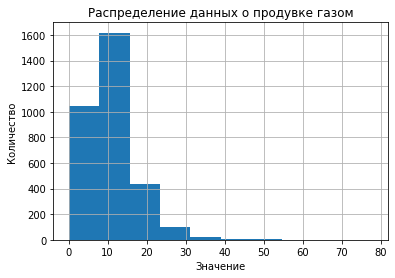

In [35]:
plt.figure()
gas_new['gas_1'].hist()
plt.title('Распределение данных о продувке газом')
plt.ylabel('Количество')
plt.xlabel('Значение')

Здесь у нас видимо отсутствует зависимость от времени в отличии от данных о подаче сыпучих материалов, а значит мы имеем только факт была продувка газом или нет. Так же нам не известно в каких единицах измерения указаны данные в столбце gas_1. Исходя из количества строк можно сделать вывод, что на каждую партию производится только одна продувка. Выбросов выявлено не было. Данная таблица в предобработке не нуждается и готова к работе

### Данные о проволочных материалах (объём)

In [36]:
wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [37]:
wire_new = wire_new.rename(
    columns = {
        'Wire 1': 'wire_1',
        'Wire 2': 'wire_2',
        'Wire 3': 'wire_3',
        'Wire 4': 'wire_4',
        'Wire 5': 'wire_5',
        'Wire 6': 'wire_6',
        'Wire 7': 'wire_7',
        'Wire 8': 'wire_8',
        'Wire 9': 'wire_9'
    }
)

In [38]:
wire_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
wire_new.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [40]:
len(wire_new['key'].unique())

3081

In [41]:
wire_new['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

Ситуация такая же как и с сыпучими материалами, скорее всего пропуски означают, что какие-то провололки не использовались в процессе производства определенной партии.

### Данные о проволочных материалах (время)

In [42]:
wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [43]:
wire_time_new = wire_time_new.rename(
    columns = {
        'Wire 1': 'wire_1',
        'Wire 2': 'wire_2',
        'Wire 3': 'wire_3',
        'Wire 4': 'wire_4',
        'Wire 5': 'wire_5',
        'Wire 6': 'wire_6',
        'Wire 7': 'wire_7',
        'Wire 8': 'wire_8',
        'Wire 9': 'wire_9'
    }
)

In [44]:
wire_time_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
for column in wire_time_new.columns:
    if column[0] == 'b':
        wire_time_new[column] = pd.to_datetime(wire_time_new[column])

In [46]:
wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [47]:
len(wire_time_new['key'].unique())

3081

In [48]:
wire_time_new['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

Text(0.5, 0, 'Наименование проволочного материала')

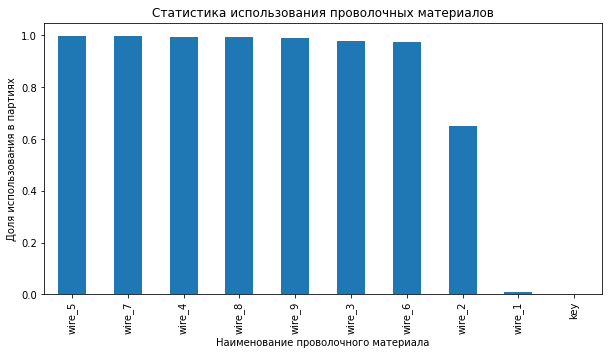

In [49]:
plt.figure(figsize = (10,5))
wire_time_new.isnull().mean().sort_values(ascending = False).plot(kind = 'bar')
plt.title('Статистика использования проволочных материалов')
plt.ylabel('Доля использования в партиях')
plt.xlabel('Наименование проволочного материала')

После объединения таблиц с данными о проволочных материалах можно будет удалить столбец wire_1

### Результаты измерения температуры

Данные из этой таблицы станут целевым признаком для обучения моделей

In [50]:
temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [51]:
temp_new.columns = ['key', 'measurement_time', 'temperature']

In [52]:
temp_new.head()

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [53]:
temp_new.describe()

,key,temperature
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [54]:
temp_new['measurement_time'] = pd.to_datetime(temp_new['measurement_time'])

In [55]:
temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               18092 non-null  int64         
 1   measurement_time  18092 non-null  datetime64[ns]
 2   temperature       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [56]:
len(temp_new['key'].unique())

3216

In [57]:
temp_new['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

<AxesSubplot:xlabel='temperature'>

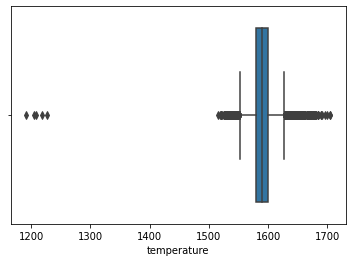

In [58]:
sns.boxplot(temp_new['temperature'])

Присутствует много пропусков. Замена пропущенных значений может привести к искажению данных, следовательно от ключей с пропусками нужно будет избавиться на этапе предобработки.

Температура плавления стали начинается с примерного порога в 1450 - это означает, что значения ниже данного порога являются выбросами и их нужно будет удалить на этапе предобработки 

### План работы <a id="work_plan"></a>

1. Подготовка данных. Предобработка и создание общей таблицы со всеми данными. Выделить целевой признак - последний замер. Разделить данные на признаки (x) и целевой признак (y).


2. Построение моделей. Выбрать модели и провести подбор гиперпараметров с помощью RandomizedSearchCV.


3. Тестирование. Проверить работу модели с наилучшим значением метркии MAE на тестовой выборке. Проверить модель на адекватность с помощью DummyRegressor. Сделать общий вывод.


4. Написание отчета.

# Подготовка данных <a id="data_preparation"></a>

In [59]:
# Удалим пропущенные значения в целевом признаке
#temp_new.dropna(inplace=True)

In [60]:
temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               18092 non-null  int64         
 1   measurement_time  18092 non-null  datetime64[ns]
 2   temperature       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Удалим значения меньше 1500 градусов

In [61]:
df = temp_new[temp_new['temperature'] >= 1500]

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14660 non-null  int64         
 1   measurement_time  14660 non-null  datetime64[ns]
 2   temperature       14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.1 KB


<AxesSubplot:xlabel='temperature'>

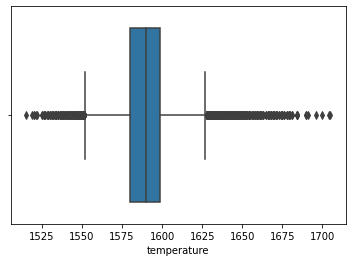

In [63]:
sns.boxplot(df['temperature'])

Удалим столбец со временем

In [64]:
df = df.drop(['measurement_time'], axis = 1)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          14660 non-null  int64  
 1   temperature  14660 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 343.6 KB


Данные с целевым признаком обработаны. Удалены пропуски, выбросы с низкой температурой и столбец со временем замера температуры.

Сгруппируем датасет по первому и последнему значению key 

In [66]:
df_first = df.groupby(['key'], axis=0, as_index=False).first()

df_last = df.groupby(['key'], axis=0, as_index=False).last() 

In [67]:
df_first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3215 entries, 0 to 3214
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3215 non-null   int64  
 1   temperature  3215 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.4 KB


In [68]:
df_last.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3215 entries, 0 to 3214
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3215 non-null   int64  
 1   temperature  3215 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.4 KB


In [69]:
df = pd.merge(df_first, df_last, how ='inner', on ='key') 

In [70]:
df.head(10)

,key,temperature_x,temperature_y
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
5,6,1543.0,1596.0
6,7,1586.0,1599.0
7,8,1577.0,1598.0
8,9,1587.0,1592.0
9,10,1574.0,1593.0


Проверим есть ли строки где совпадает замер начальной и конечной температуры. Их нужно будет удалить тк это скорее всего какая-то ошибка в заполнении данных и она может повлиять на качество модели.

In [71]:
df['same_temp'] = df['temperature_x'] == df['temperature_y']

df['same_temp'].sum()

783

Мы получили 783 ключа с одинаковой температурой в первом и последнем измерении. Удалим их.

In [72]:
df = df[df['same_temp'] == False]

In [73]:
df = df.drop('same_temp', axis = 1)

In [74]:
df.columns=['key', 'temp_first', 'temp_last']

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2432 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2432 non-null   int64  
 1   temp_first  2432 non-null   float64
 2   temp_last   2432 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 76.0 KB


Данные с целывым признаком готовы к дальнейшей работе

In [76]:
arc_new.head()

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Удалим ключ с отрицательной реактивной мощностью

In [77]:
arc_new = arc_new[arc_new['reactive_power'] > 0]

In [78]:
arc_new.describe()

,key,active_power,reactive_power
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115
std,934.593897,0.258894,0.197612
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337190
50%,1617.000000,0.599578,0.441665
75%,2429.000000,0.830135,0.608223
max,3241.000000,1.463773,1.270284


Посчитаем время нагрева для каждого этапа 

In [79]:
arc_new['time'] = ((arc_new['arc_heating_end'] - arc_new['arc_heating_start']) / np.timedelta64(1, 'm')).astype('int')  

In [80]:
arc_new.head()

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,3
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,3
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,2
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,6
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,2


Посчитаем общее время и суммарную мощность для каждого key и сгруппируем

In [81]:
arc_group = arc_new.groupby(['key'], axis=0, as_index=False).sum()

In [82]:
arc_group.head()

,key,active_power,reactive_power,time
0,1,3.036730,2.142821,16
1,2,2.139408,1.453357,12
2,3,4.063641,2.937457,9
3,4,2.706489,2.056992,10
4,5,2.252950,1.687991,13


Выделим из полученного датасета интересующие нас данные

In [83]:
df_arc = arc_group.drop('reactive_power', axis = 1)

In [84]:
df_arc.head()

,key,active_power,time
0,1,3.036730,16
1,2,2.139408,12
2,3,4.063641,9
3,4,2.706489,10
4,5,2.252950,13


Объединим таблицы df_arc и df по key 

In [85]:
df = df.merge(df_arc, on = 'key', how = 'inner')

In [86]:
df.head()

,key,temp_first,temp_last,active_power,time
0,1,1571.0,1613.0,3.036730,16
1,2,1581.0,1602.0,2.139408,12
2,3,1596.0,1599.0,4.063641,9
3,4,1601.0,1625.0,2.706489,10
4,5,1576.0,1602.0,2.252950,13


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2432 entries, 0 to 2431
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2432 non-null   int64  
 1   temp_first    2432 non-null   float64
 2   temp_last     2432 non-null   float64
 3   active_power  2432 non-null   float64
 4   time          2432 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 114.0 KB


Заполним пропуски в данных о сыпучих материалах нулями

In [88]:
bulk_new = bulk_new.fillna(0)

Обьединим с таблицей df

In [89]:
df = df.merge(bulk_new, on = 'key', how = 'inner')

In [90]:
df.head()

,key,temp_first,temp_last,active_power,time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,1571.0,1613.0,3.036730,16,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,1581.0,1602.0,2.139408,12,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,1596.0,1599.0,4.063641,9,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,1601.0,1625.0,2.706489,10,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,1576.0,1602.0,2.252950,13,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2364 entries, 0 to 2363
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2364 non-null   int64  
 1   temp_first    2364 non-null   float64
 2   temp_last     2364 non-null   float64
 3   active_power  2364 non-null   float64
 4   time          2364 non-null   int64  
 5   bulk_1        2364 non-null   float64
 6   bulk_2        2364 non-null   float64
 7   bulk_3        2364 non-null   float64
 8   bulk_4        2364 non-null   float64
 9   bulk_5        2364 non-null   float64
 10  bulk_6        2364 non-null   float64
 11  bulk_7        2364 non-null   float64
 12  bulk_8        2364 non-null   float64
 13  bulk_9        2364 non-null   float64
 14  bulk_10       2364 non-null   float64
 15  bulk_11       2364 non-null   float64
 16  bulk_12       2364 non-null   float64
 17  bulk_13       2364 non-null   float64
 18  bulk_14       2364 non-null 

Добавим в итоговую таблицу данные о продувке газом

In [92]:
gas_new.isnull().sum()

key      0
gas_1    0
dtype: int64

In [93]:
df = df.merge(gas_new, on = 'key', how = 'inner')

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2362 entries, 0 to 2361
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2362 non-null   int64  
 1   temp_first    2362 non-null   float64
 2   temp_last     2362 non-null   float64
 3   active_power  2362 non-null   float64
 4   time          2362 non-null   int64  
 5   bulk_1        2362 non-null   float64
 6   bulk_2        2362 non-null   float64
 7   bulk_3        2362 non-null   float64
 8   bulk_4        2362 non-null   float64
 9   bulk_5        2362 non-null   float64
 10  bulk_6        2362 non-null   float64
 11  bulk_7        2362 non-null   float64
 12  bulk_8        2362 non-null   float64
 13  bulk_9        2362 non-null   float64
 14  bulk_10       2362 non-null   float64
 15  bulk_11       2362 non-null   float64
 16  bulk_12       2362 non-null   float64
 17  bulk_13       2362 non-null   float64
 18  bulk_14       2362 non-null 

In [95]:
wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Удалим столбец wire_1 тк процент подачи этого проволочного материала близок к 0

In [96]:
wire_new = wire_new.drop('wire_1', axis = 1)

Заполним пропуски нулями

In [97]:
wire_new = wire_new.fillna(0)

In [98]:
wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_2  3081 non-null   float64
 2   wire_3  3081 non-null   float64
 3   wire_4  3081 non-null   float64
 4   wire_5  3081 non-null   float64
 5   wire_6  3081 non-null   float64
 6   wire_7  3081 non-null   float64
 7   wire_8  3081 non-null   float64
 8   wire_9  3081 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 216.8 KB


Добавим в итоговую таблицу полученные данные о подаче проволочных материалом

In [99]:
df = df.merge(wire_new, on = 'key', how = 'inner')

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2292 entries, 0 to 2291
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2292 non-null   int64  
 1   temp_first    2292 non-null   float64
 2   temp_last     2292 non-null   float64
 3   active_power  2292 non-null   float64
 4   time          2292 non-null   int64  
 5   bulk_1        2292 non-null   float64
 6   bulk_2        2292 non-null   float64
 7   bulk_3        2292 non-null   float64
 8   bulk_4        2292 non-null   float64
 9   bulk_5        2292 non-null   float64
 10  bulk_6        2292 non-null   float64
 11  bulk_7        2292 non-null   float64
 12  bulk_8        2292 non-null   float64
 13  bulk_9        2292 non-null   float64
 14  bulk_10       2292 non-null   float64
 15  bulk_11       2292 non-null   float64
 16  bulk_12       2292 non-null   float64
 17  bulk_13       2292 non-null   float64
 18  bulk_14       2292 non-null 

### Изучим полученный набор данных

In [101]:
df.corr()

,key,temp_first,temp_last,active_power,time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,bulk_15,gas_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,1.000000,-0.018283,-0.101490,-0.021744,-0.035911,-0.073973,-0.005953,-0.005445,-0.027461,0.035940,...,-0.044507,-0.044232,0.045520,-0.027019,0.049866,NaN,-0.007853,0.037396,-0.035982,0.021832
temp_first,-0.018283,1.000000,0.295912,-0.158516,-0.396098,0.080698,0.142058,-0.113725,0.162868,0.079260,...,-0.065191,0.036351,-0.099350,-0.003044,0.076478,NaN,0.021131,0.053011,-0.029664,0.002935
temp_last,-0.101490,0.295912,1.000000,0.173767,0.284915,-0.074575,-0.083297,-0.036570,0.184705,-0.028685,...,0.266341,0.058043,-0.206924,-0.048055,-0.161315,NaN,-0.084913,-0.138620,-0.010902,-0.027797
active_power,-0.021744,-0.158516,0.173767,1.000000,0.672503,0.102387,0.091488,0.099998,0.002684,0.073457,...,0.167861,0.371044,0.064595,0.054853,0.103654,NaN,0.056350,0.061784,0.034529,-0.023913
time,-0.035911,-0.396098,0.284915,0.672503,1.000000,0.108116,0.023896,0.082738,-0.034981,0.000515,...,0.304432,0.376465,0.052409,0.025085,0.038917,NaN,0.036482,0.015670,0.019252,-0.008323
bulk_1,-0.073973,0.080698,-0.074575,0.102387,0.108116,1.000000,0.226154,-0.010730,0.042020,0.060731,...,-0.000347,0.239322,-0.011828,0.020301,0.147230,NaN,0.149470,0.083977,-0.019734,0.011054
bulk_2,-0.005953,0.142058,-0.083297,0.091488,0.023896,0.226154,1.000000,-0.047432,0.041320,0.360217,...,-0.106584,0.218578,-0.039407,0.223097,0.699320,NaN,0.558836,0.431722,-0.005359,-0.006953
bulk_3,-0.005445,-0.113725,-0.036570,0.099998,0.082738,-0.010730,-0.047432,1.000000,-0.294046,-0.007336,...,-0.013088,0.057360,0.096414,0.005315,-0.040996,NaN,0.006668,-0.019673,0.004569,0.004253
bulk_4,-0.027461,0.162868,0.184705,0.002684,-0.034981,0.042020,0.041320,-0.294046,1.000000,0.028898,...,0.102678,0.017007,-0.266854,-0.039212,0.034870,NaN,-0.011198,0.034180,0.008087,-0.058347
bulk_5,0.035940,0.079260,-0.028685,0.073457,0.000515,0.060731,0.360217,-0.007336,0.028898,1.000000,...,-0.067921,0.087041,-0.014216,0.070712,0.262679,NaN,0.204649,0.172103,-0.008473,-0.010993


<AxesSubplot:>

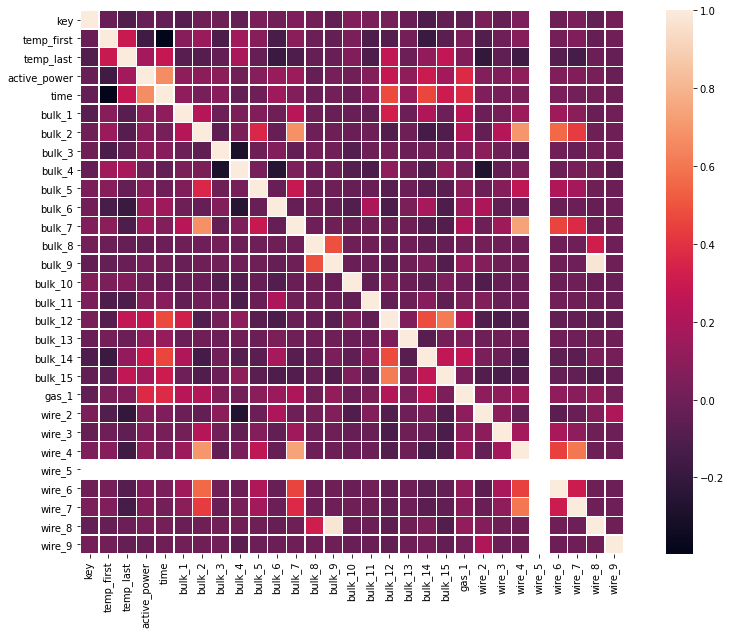

In [102]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), square=True, linewidths=.5)

По матрице корреляции можно сделать слующие выводы:

Присутствует очень сильная корреляция между столбами wire_8 и bulk_9,

Столбец wire_5 по - видимому состоит из одних нулей, следовательно корреляция не просчитывается (его мы удалим).


Так как мы будем использовать линейную регрессию нужно избавиться от высококоррелирующих признаков,  может сильно повлиять на качество модели.

In [103]:
df = df.drop(['wire_5', 'bulk_9'], axis = 1)

Для дальнейшей работы столбец key нам уже не потребуется, его мы тоже удаляем

In [104]:
df = df.drop('key', axis = 1)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2292 entries, 0 to 2291
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp_first    2292 non-null   float64
 1   temp_last     2292 non-null   float64
 2   active_power  2292 non-null   float64
 3   time          2292 non-null   int64  
 4   bulk_1        2292 non-null   float64
 5   bulk_2        2292 non-null   float64
 6   bulk_3        2292 non-null   float64
 7   bulk_4        2292 non-null   float64
 8   bulk_5        2292 non-null   float64
 9   bulk_6        2292 non-null   float64
 10  bulk_7        2292 non-null   float64
 11  bulk_8        2292 non-null   float64
 12  bulk_10       2292 non-null   float64
 13  bulk_11       2292 non-null   float64
 14  bulk_12       2292 non-null   float64
 15  bulk_13       2292 non-null   float64
 16  bulk_14       2292 non-null   float64
 17  bulk_15       2292 non-null   float64
 18  gas_1         2292 non-null 

In [106]:
df.tail(20)

,temp_first,temp_last,active_power,time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_14,bulk_15,gas_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
2272,1564.0,1594.0,4.116267,12,0.0,0.0,185.0,99.0,0.0,0.0,...,178.0,103.0,17.371982,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2273,1576.0,1601.0,3.038059,11,0.0,0.0,130.0,0.0,0.0,0.0,...,181.0,105.0,9.248102,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2274,1556.0,1595.0,3.600131,14,0.0,0.0,146.0,30.0,0.0,0.0,...,149.0,103.0,17.437711,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2275,1559.0,1598.0,4.421327,14,0.0,0.0,121.0,94.0,0.0,0.0,...,149.0,104.0,14.220873,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2276,1569.0,1598.0,2.667037,16,0.0,0.0,0.0,79.0,0.0,0.0,...,246.0,103.0,14.214662,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2277,1635.0,1592.0,1.104213,4,0.0,0.0,0.0,47.0,0.0,0.0,...,119.0,103.0,3.361715,11.038560,0.0,0.0,0.0,0.0,0.0,0.0
2278,1582.0,1616.0,3.316613,15,0.0,0.0,0.0,98.0,0.0,0.0,...,209.0,104.0,13.050460,42.103359,0.0,0.0,0.0,0.0,0.0,0.0
2279,1589.0,1592.0,0.819979,5,0.0,0.0,0.0,49.0,0.0,0.0,...,98.0,104.0,5.976477,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2280,1568.0,1583.0,5.262919,17,0.0,0.0,0.0,0.0,0.0,121.0,...,221.0,105.0,20.135799,85.413121,0.0,0.0,0.0,0.0,0.0,0.0
2281,1602.0,1577.0,3.687733,8,0.0,0.0,23.0,0.0,0.0,0.0,...,140.0,105.0,28.306153,37.066639,0.0,0.0,0.0,0.0,0.0,0.0


### Вывод

1. Мы удалили такие аномалии как отрицательная реактивная мощность и температура меньше 1500 градусов.

2. Выделили начальную и конечную температуру.

3. Посчитали общее время и суммарную мощность для каждого key. Создали новый признак time - общее время нагрева для каждого этапа в минутах.

4. Заполнили пропуски нулями. Также было принято решение удалить столбец wire_1 тк он практически полностью состоял из пропусков.

5. Обьединили все признаки в итоговый датафрейм df по столбцу key.

6. Построили матрицу корреляции полученных признаков. 

Удалилили столбец wire_5 тк он полностью состоит из нулей. 

Удалили столбец bulk_9 потому что он слишком сильно коррелирует со столбцом wire_8, а это может помешать при обучении модели линейной регрессии.

Удалили столбец key, он был нужен нам только для объединения признаков, а в обучении модели он не потребуется.


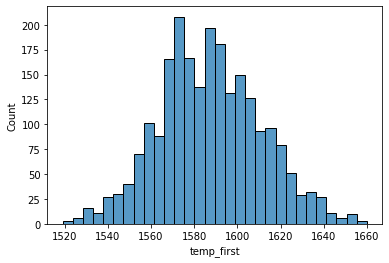

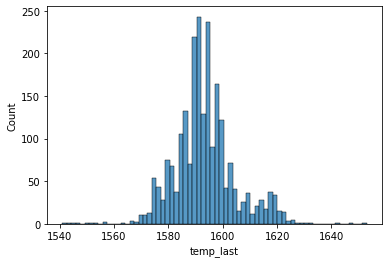

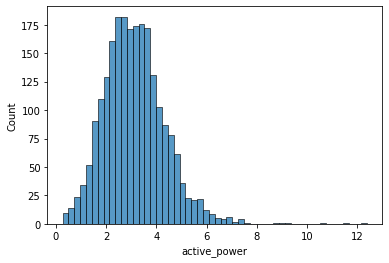

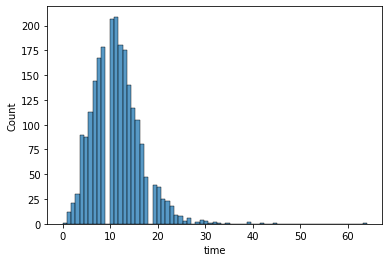

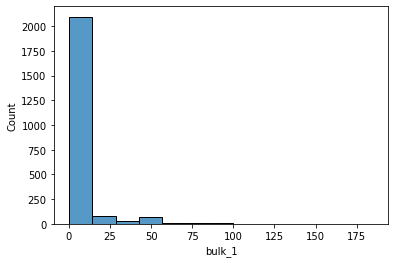

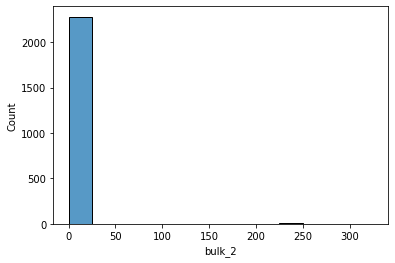

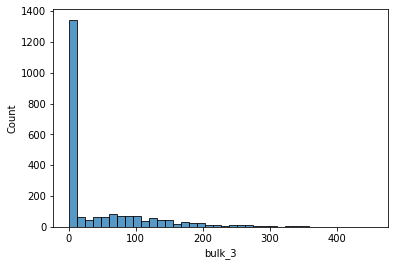

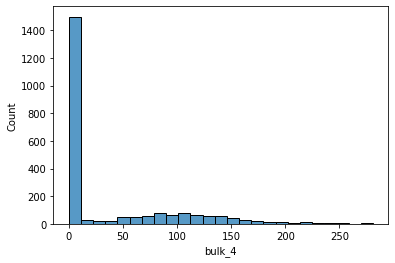

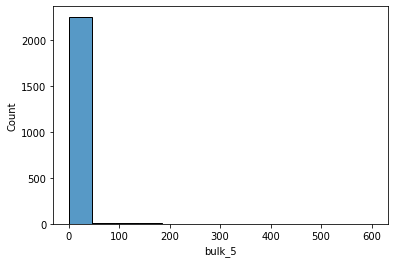

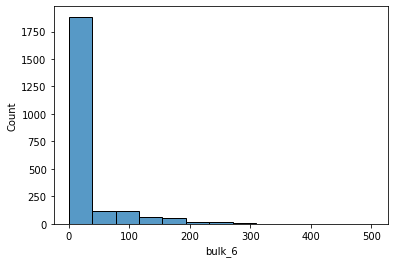

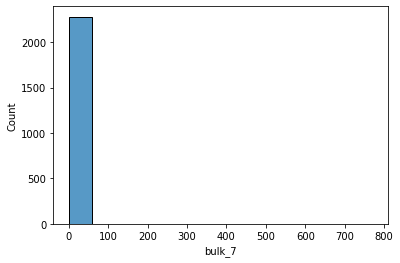

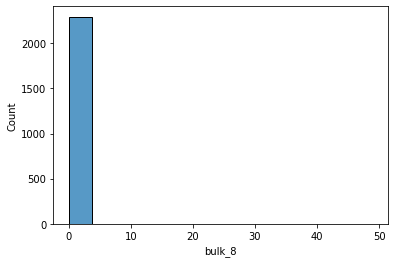

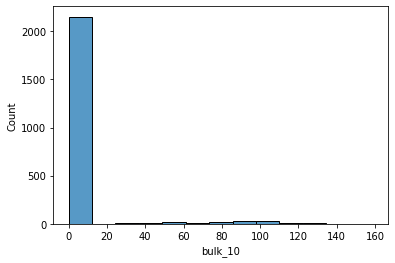

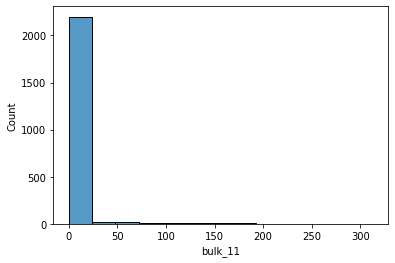

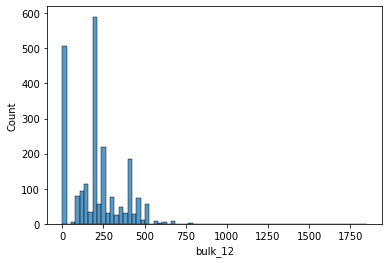

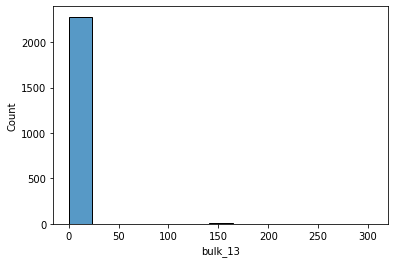

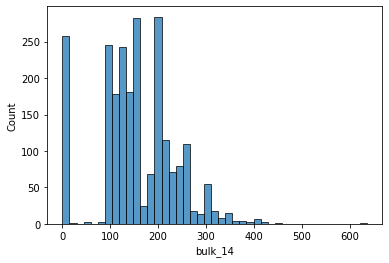

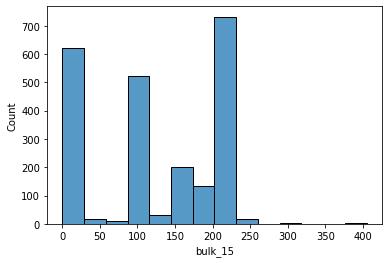

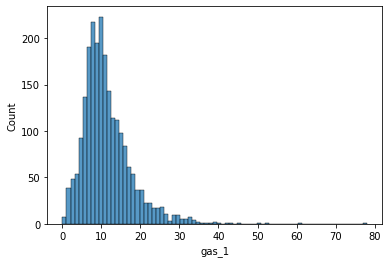

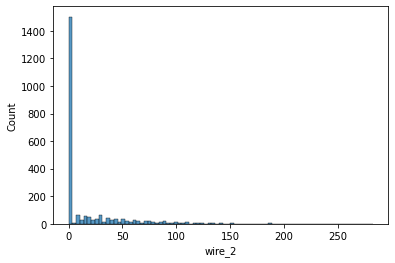

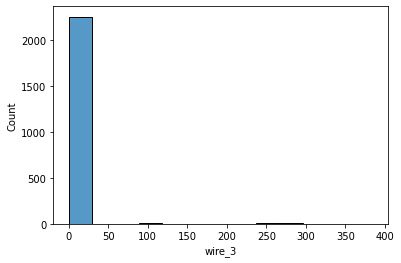

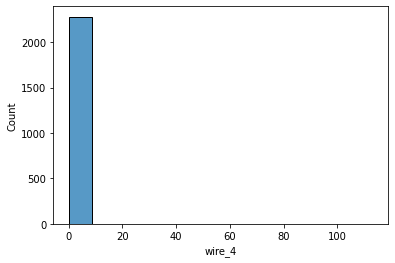

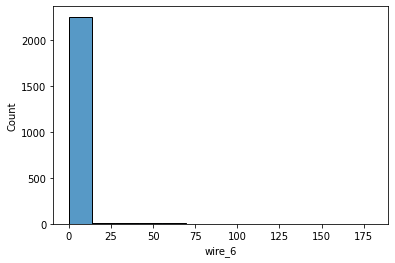

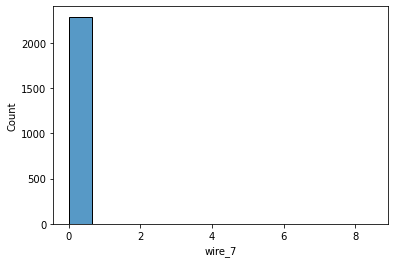

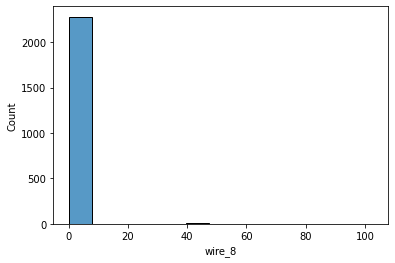

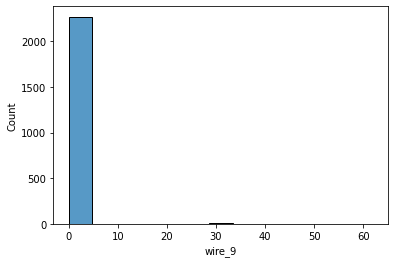

In [107]:
for column in df:
  sns.histplot(df, x = column, multiple = 'stack')
  plt.show()

# Построение моделей  <a id="building_models"></a>

In [108]:
RANDOM_STATE = np.random.RandomState(170723)

Разделим датафрейм на признаки и целевой признак - конечная температура (temp_last)

In [109]:
X = df.drop(['temp_last'], axis=1)
y = df['temp_last']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = RANDOM_STATE)

In [111]:
X_train.shape

(1719, 25)

In [112]:
y_train.shape

(1719,)

In [113]:
X_test.shape

(573, 25)

Масштабируем признаки, исполльзуя StandardScaler

In [114]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [115]:
X_train.shape

(1719, 25)

In [116]:
# определим гиперпараметры для каждой модели
param_distributions = {
    'Linear Regression': {'alpha': uniform(0.001, 1)},
        
    'Random Forest': {'n_estimators': randint(100, 200, 500),
                      'max_depth': randint(1, 20),
                      'min_samples_split': randint(2, 20)},
}

models = [('Linear Regression', Ridge(random_state = RANDOM_STATE)),
          ('Random Forest', RandomForestRegressor(random_state = RANDOM_STATE))]


# создадим MAE scorer
scorer = make_scorer(mean_absolute_error, greater_is_better = False)

for name, model in models:
    random_search = RandomizedSearchCV(estimator = model,
                                       param_distributions = param_distributions[name],
                                       n_iter = 10,
                                       verbose = 2,
                                       cv = 5,
                                       scoring = scorer,
                                       random_state = RANDOM_STATE)

    # обучаем random search на тренировачной выборке
    random_search.fit(X_train, y_train)

    # получаем лучшие гиперпараметры
    best_params = random_search.best_params_
    print(f"Best params for {name} : {best_params}")

    # обучаем и оцениваем модель на лучших гиперпараметрах 
    best_model = model.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    print(name + ':')
    print('Best score: ', random_search.best_score_ * -1)
    print()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...........................alpha=0.8627424931092645; total time=   0.0s
[CV] END ...........................alpha=0.8627424931092645; total time=   0.0s
[CV] END ...........................alpha=0.8627424931092645; total time=   0.0s
[CV] END ...........................alpha=0.8627424931092645; total time=   0.0s
[CV] END ...........................alpha=0.8627424931092645; total time=   0.0s
[CV] END ............................alpha=0.912252431193288; total time=   0.1s
[CV] END ............................alpha=0.912252431193288; total time=   0.0s
[CV] END ............................alpha=0.912252431193288; total time=   0.1s
[CV] END ............................alpha=0.912252431193288; total time=   0.0s
[CV] END ............................alpha=0.912252431193288; total time=   0.0s
[CV] END ..........................alpha=0.46738852863272407; total time=   0.1s
[CV] END ..........................alpha=0.46738

1. Best params for Linear Regression : {'alpha': 0.912252431193288}

Linear Regression:

Best score:  6.417150806812183

2. Best params for Random Forest : {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 626}

Random Forest:

Best score:  6.295778113450734

### Проверим лучшую модель на тестовой выборке

Best params for Random Forest : {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 626}

Random Forest

Best score:  6.295778113450734

In [117]:
# Создание модели RandomForestRegressor
rf = RandomForestRegressor(max_depth = 10, 
                           min_samples_split = 10,
                           n_estimators = 626,
                           random_state = RANDOM_STATE)

# Обучение модели
rf.fit(X_train, y_train)

# Предсказание на тестовом наборе данных
y_pred_rf = rf.predict(X_test)

# Оценка качества модели
MAE_test_rf = mean_absolute_error(y_pred_rf, y_test)

print('Random Forest MAE test:', MAE_test_rf)

Random Forest MAE test: 6.399752096902537


Random Forest MAE test: 6.399752096902537

In [118]:
# Рассчитываем метрику R2 для RandomForestRegressor
r2_rf = r2_score(y_test, y_pred_rf)

print('Random Forest R2 score :', r2_rf)

Random Forest R2 score : 0.378010297442425


Random Forest R2 score : 0.378010297442425

Метрика R2 дает слишком низкий результат относительно единицы, следовательно на практике модель может показать себя недостаточно хорошо. Возможно это связано с тем, что присутствуют признаки с очень низкой важностью, либо заполнение пропусков нулями было не самым лучшим решением и слодовало поступить иначе. 

### Проверим модель на адекватность

In [119]:
dummy_model = DummyRegressor(strategy="mean")

dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)

MAE_dummy = mean_absolute_error(y_pred_dummy, y_test)

print("Dummy Test MAE:", MAE_dummy)

Dummy Test MAE: 8.28926676189636


Dummy Test MAE: 8.28926676189636

### Исследуем важность признаков лучшей модели

In [120]:
# Получаем важность признаков
importance = rf.feature_importances_
feature_names = ['temp_first', 'active_power', 'time', 'bulk_1', 'bulk_2', 
                 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_10',
                 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas_1',
                 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

# Сортируем признаки по важности
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance.sort_values('Importance', ascending = False, inplace = True)

# Выводим результаты
print(feature_importance)

         Feature  Importance
0     temp_first    0.244438
2           time    0.206457
8         bulk_6    0.091925
17         gas_1    0.060214
16       bulk_15    0.057152
1   active_power    0.047722
15       bulk_14    0.046739
18        wire_2    0.045513
13       bulk_12    0.038464
9         bulk_7    0.035136
5         bulk_3    0.025865
6         bulk_4    0.022487
4         bulk_2    0.013435
22        wire_7    0.011998
3         bulk_1    0.011194
20        wire_4    0.010646
12       bulk_11    0.008535
21        wire_6    0.007690
19        wire_3    0.007655
11       bulk_10    0.004277
7         bulk_5    0.001287
24        wire_9    0.000626
23        wire_8    0.000291
14       bulk_13    0.000254
10        bulk_8    0.000000


         Feature  Importance
         
0     temp_first    0.244438

2           time    0.206457

8         bulk_6    0.091925

17         gas_1    0.060214

16       bulk_15    0.057152

1   active_power    0.047722

15       bulk_14    0.046739

18        wire_2    0.045513

13       bulk_12    0.038464

9         bulk_7    0.035136

5         bulk_3    0.025865

6         bulk_4    0.022487

4         bulk_2    0.013435

22        wire_7    0.011998

3         bulk_1    0.011194

20        wire_4    0.010646

12       bulk_11    0.008535

21        wire_6    0.007690

19        wire_3    0.007655

11       bulk_10    0.004277

7         bulk_5    0.001287

24        wire_9    0.000626

23        wire_8    0.000291

14       bulk_13    0.000254

10        bulk_8    0.000000

Основываясь на результатах оценки features importance, мы можем наблюдать следующее:

1. Наиболее значимыми признаками являются 'temp_first' и 'time'. Это указывает на то, что начальная температура и общее время нагрева стали оказывает наибольшее влияние на эффективность.


2. На втором месте такие пизнаки как 'bulk_6' и 'gas_1'. Это говорит о том, что подача определенного количества газа и сыпучего материала под номером 6 также играет решающую роль в определении эффективности.


3. На третьем месте такие пизнаки как 'active_power', 'bulk_15'. Количество сыпучих материалов bulk_15 и активная мощность также являются важным фактором, влияющим на эффективность.


4. Другие признаки, такие как наличие добавок в виде сыпучих метериалов 'bulk_14' и 'wire_2' имеют среднюю важность, которая указывают на их небольшую значимость в процессе обработки стали.

Оставшиеся признаки имеют очень низкие оценки значимости, такие как. Эти признаки могут не вносить существенного вклада в эффективность прогнозирования модели и потенциально могут быть удалены в будущих анализах, чтобы упростить модель без значительного ущерба для точности.

# Вывод <a id="conclusion"></a>

Вывод

В данном проекте основной целью было построить модель, которая предскажет температуру стали, поможет оптимизировать расходы и энергопотребление на этапе обработки.

1. В процессе анализа данных было обнаружено много пропусков и несколько аномалий.


2. На этапе предобработки было сделано следующее:

Мы удалили такие аномалии как отрицательная реактивная мощность и температура меньше 1500 градусов.

Выделили начальную и конечную температуру.

Посчитали общее время и суммарную мощность для каждого key. 

Создали новый признак time - общее время нагрева для каждого этапа в минутах.

Заполнили пропуски нулями. 

Было принято решение удалить столбец wire_1 тк он практически полностью состоял из пропусков.

Обьединили все признаки в итоговый датафрейм df по столбцу key.

Построили матрицу корреляции полученных признаков. 

Удалилили столбец wire_5 тк он полностью состоит из нулей. 

Удалили столбец bulk_9 потому что он слишком сильно коррелирует со столбцом wire_8, а это могло помешать при обучении моделей.

Удалили столбец key, он был нужен нам только для объединения признаков, а в обучении модели он не потребуется.

3. Проверили модели Linear Regression и Random Forest на тренировочной выборке. 

Наилучший результат показала модель Random Forest:

RandomForestRegressor MAE = 6.29


4. На тестовой выборке модель RandomForestRegressor с гиперпараметрами:

max_depth = 10, min_samples_split = 10, n_estimators = 626

Random Forest MAE test: 6.38, что соответствует требованиям заказчика, значит цель достигнута.

5. Провели анализ важности признаков для модели.

Наиболее значимыми признаками являются 'temp_first' и 'time'. Это указывает на то, что начальная температура и общее время нагрева стали оказывает наибольшее влияние на эффективность.

На втором месте такие пизнаки как 'bulk_6' и 'gas_1'. Это говорит о том, что подача определенного количества газа и сыпучего материала под номером 6 также играет решающую роль в определении эффективности.

На третьем месте такие пизнаки как 'active_power', 'bulk_15'. Количество сыпучих материалов bulk_15 и активная мощность также являются важным фактором, влияющим на эффективность.


6. Была использована константная модель для выявления адекватности модели. Модель RandomForestRegressor превзошла константную модель по тестовым данным, что указывает на ее эффективность в прогнозировании температуры стали. RandomForestRegressor MAE = 6.38 против DummyRegressor = 8.28.



## Отчет <a id="report"></a>

### Сравнение решения и плана, если есть отклонение, то нужно объясняснить, почему какие-то пункты не выполнены

Все пункты выполнены в полном соответствии с планом работы.


План работы 

1.	Подготовка данных. Предобработка и создание общей таблицы со всеми данными. Выделить целевой признак - последний замер. Разделить данные на признаки (x) и целевой признак (y).

2.	Построение моделей. Выбрать модели и провести подбор гиперпараметров с помощью RandomizedSearchCV.

3.	Тестирование. Проверить работу модели с наилучшим значением метркии MAE на тестовой выборке. Проверить модель на адекватность с помощью DummyRegressor. Сделать общий вывод.

4.	Написание отчета.



### Описание трудностей проекта и как они были решены

Сложность данного проекта заключалась в том, чтобы правильно подготовить таблицу с признаками и целевым признаком, по которой будут обучаться модели. Поэтому сначала была проведена подготовка целевого признака и в дальнейшем уже по полученным ключам мы добавляли данные из других таблиц.

Так же потребовалось углубиться в процесс работы чтобы определить какие данные из таблиц понадобятся в качестве признаков для обучения моделей, а какие можно будет отбросить. 

Сомнение вызвало решение заказчика заполнить большое количество пропусков в таблицах о подаче сыпучих и проволочных материалов нулями. Возможно такое решение и привело к тому, что в процессе исследования важности признаков для итоговой модели, больше 50% этих признаков имели очень низкую степень значимости и эти пропуски следовало обработать по-другому.

### Описание ключевых шагов решения (если их нет, то нужно написать "ключевых шагов решения нет")

1. Провели анализ данных из всех таблиц, построили графики и составили план работы.


2. Выполнили предобработку данных. На этом этапе начали создавать итоговую таблицу с признаками и целевым признаком для обучения и тестирования моделей.


3. Изучили полученный набор данных. Построили график корреляции признаков, удалили высоко коррелирующие признаки. Вывели все графики распределения признаков в итоговой таблице.


4. Разделили датафрейм на тренировочную и тестовую выборки. Сделали масштабирование признаков, используя StandardScaler. Обучили 2 модели, линейная регрессия и рандомный лес, на тренировочной выборке с кросс- валидацией. 


5. Проверили работу лучшей модели на тестовой выборке, а также сравнили с результатом работы константной модели для проверки на адекватность предсказаний. Исследовали важность признаков для лучшей модели и написали вывод.


6. Написание общего вывода по проведенному исследованию.


### Все признаки, которые использовали для обучения Итоговой модели и описать конкретно, как все эти признаки предобрабатывались (нужно рассказать именно про все признаки Итоговой модели)

Первым делом мы подготовили целевой признак, используя данные из таблицы data_temp_new.csv — результаты измерения температуры. Нам известно, что температура плавления стали начинается с 1500 градусов, поэтому ключи с измерениями менее 1500 градусов были удалены из таблицы. После удаления этих ключей мы построили график boxplot чтобы убедиться, что не осталось аномальных выбросов и все температуры находятся в правильном диапазоне. Столбец со временем замера температуры был удален, потому что эти данные для обучения модели не нужны. Из полученной таблицы создали два новых датасета в которых сгруппировали данные по первому и последнему замеру температуры. Затем создаем новый датасет методом merge для объединения таблиц, в который вносим первый замер – начальную температуру и последний замер – конечную температуру, который станет целевым признаком для наших моделей. Проверили таблицу на наличие строк с одинаковым измерением начальной и конечной температуры. Такого быть не должно, поэтому ключи с этими данными тоже были удалены. В итоге мы получили таблицу df, с которой дальше будем работать и добавлять в неё оставшиеся признаки для обучения моделей.

В таблице data_arc_new.csv — данные об электродах было обнаружено значение с отрицательной реактивной мощностью, по согласованию с заказчиком эти данные были удалены из таблицы. Затем мы создали новый признак time – время нагрева для каждого этапа. Для каждого ключа посчитали общее время и суммарную мощность. Данные с реактивной мощностью были удалены из таблицы, для обучения модели они нам не понадобятся. Оставшиеся данные внесли в таблицу df объединив по ключу.

В таблице data_bulk_new.csv — данные о подаче сыпучих материалов (объём) было обнаружено много пропусков, из мы заполнили нулями по требованию заказчика и объединили данные с таблицей df по ключу с помощью merge. 

В таблице data_gas_new.csv — данные о продувке сплава газом пропусков или дубликатов мы не обнаружили, значит в предобработке она не нуждается. Сразу объединяем её с таблицей df по ключу методом merge.

В таблице data_wire_new.csv — данные о проволочных материалах (объём) тоже было обнаружено много пропусков. В столбце wire_1 пропусков более 80%, а значит заполнять эти пропуску нулями нет смысла, это может привести к искажению предсказаний будущей модели. Поэтому было принято решение удалить столбец wire_1. После заполнения оставшихся пропусков нулями мы объединили данные о подаче проволочных материалов с итоговой таблицей df по ключу.

Таблицы со временем data_bulk_time_new.csv — данные о подаче сыпучих материалов (время) и data_wire_time_new.csv — данные о проволочных материалах (время) на этапе предобработки и подготовки признаков не использовались, для обучения модели они нам не потребуются.


### Полное описание Итоговой модели (с гиперпараметрами, включая random_state, если был использован) и итоговая метрика на тестовой выборке

На тренировочной выборке лучший результат показала модель случайного леса RandomForestRegressor MAE = 6.29. 

С гиперпараметрами:

max_depth = 10, min_samples_split = 10, n_estimators = 626, random_state = 170723

На тестовой выборке модель показала результат MAE = 6.38, что соответствует требованиям заказчика.

Мы провели анализ важности признаков для итоговой модели.

Наиболее значимыми признаками являются 'temp_first' и 'time'. Это указывает на то, что начальная температура и общее время нагрева стали оказывает наибольшее влияние на эффективность.

На втором месте такие пизнаки как 'bulk_6' и 'gas_1'. Это говорит о том, что подача определенного количества газа и сыпучего материала под номером 6 также играет решающую роль в определении эффективности.

На третьем месте такие пизнаки как 'active_power', 'bulk_15'. Количество сыпучих материалов bulk_15 и активная мощность также являются важным фактором, влияющим на эффективность.

Оставшиеся признаки имеют очень низкие оценки значимости, такие как. Эти признаки могут не вносить существенного вклада в эффективность прогнозирования модели и потенциально могут быть удалены в будущих анализах, чтобы упростить модель без значительного ущерба для точности.

Для проверки адекватности модели была использована константная модель. Модель RandomForestRegressor превзошла константную модель по тестовым данным, что указывает на ее эффективность в прогнозировании температуры стали. RandomForestRegressor MAE = 6.38 против DummyRegressor = 8.28.